In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
from torch.nn import Module,Conv2d,Linear,ReLU,Sigmoid,Tanh,MaxPool2d,Sequential,BatchNorm2d,Dropout,CrossEntropyLoss
from torch.optim import SGD,Adagrad,Adam
from sklearn.model_selection import KFold

/home/shwetank/Desktop/ShwetankAssignmentMT2025725/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform_basic = transforms.ToTensor()

temp = datasets.CIFAR10(root='./data',train=True,download=False,transform=transform_basic)

loader = DataLoader(temp,batch_size=500,shuffle=False,num_workers=2)

mean,std = 0.0,0.0
total_images_count = 0

for images,_ in tqdm(loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples,images.size(1),-1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += batch_samples

mean /= total_images_count
std /= total_images_count

print('Mean:',mean)
print('Standard Deviation:',std)

100%|██████████| 100/100 [00:02<00:00, 35.18it/s]

Mean: tensor([0.4914, 0.4822, 0.4465])
Standard Deviation: tensor([0.2023, 0.1994, 0.2010])


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

full_train_dataset = datasets.CIFAR10(root='./data',train=True,transform=train_transform,download=False)
test_dataset = datasets.CIFAR10(root='./data',train=False,transform=test_transform,download=False)

# train_size = int(0.85*len(full_train_dataset))
# val_size = len(full_train_dataset) - train_size

# train_dataset, val_dataset = random_split(full_train_dataset,[train_size,val_size])

# train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=2)
# val_loader = DataLoader(val_dataset,batch_size=64,shuffle=True,num_workers=2)

test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True,num_workers=2)

100%|██████████| 50000/50000 [00:11<00:00, 4291.89it/s]


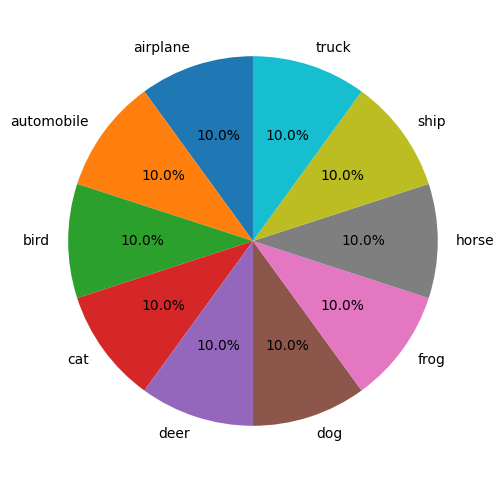

In [4]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

labels = []

for td in tqdm(full_train_dataset):
    _,label = td
    labels.append(label)

labels = np.array(labels)

_,count = np.unique(labels,return_counts=True)

plt.figure(figsize=(10,6))
plt.pie(count,autopct='%1.1f%%',labels=class_names,startangle=90)
plt.show()

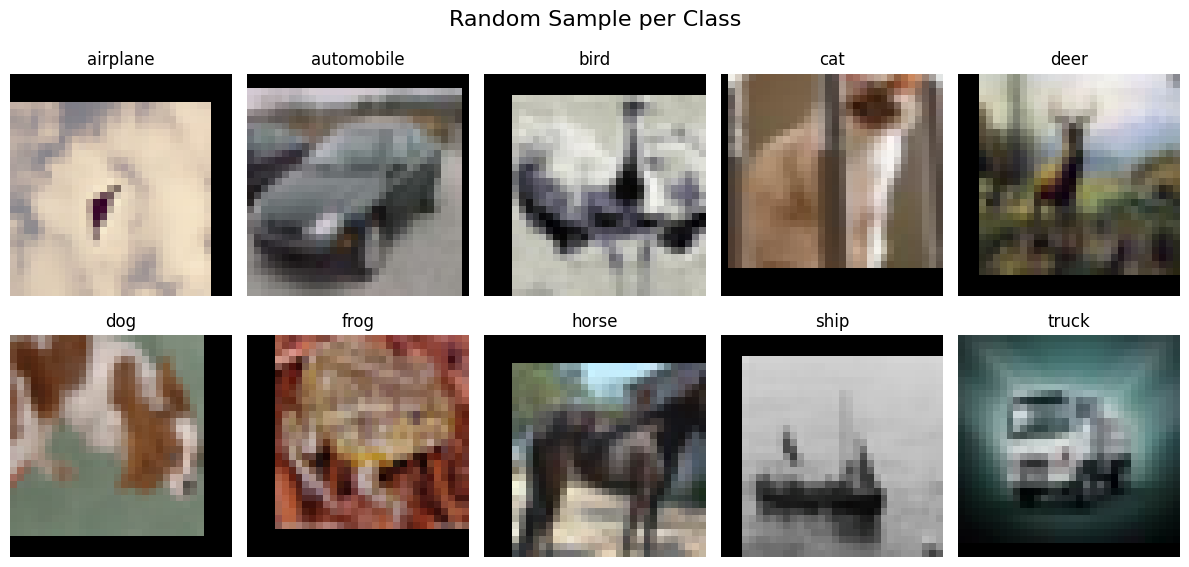

In [5]:
import random

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i, cls in enumerate(class_names):
    idx = [j for j, (_, label) in enumerate(full_train_dataset) if label == i]
    img, _ = full_train_dataset[random.choice(idx)]
    img = img * std[:, None, None] + mean[:, None, None]  # unnormalize
    img = torch.clamp(img, 0, 1)
    axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[i].set_title(cls)
    axes[i].axis('off')

plt.suptitle("Random Sample per Class", fontsize=16)
plt.tight_layout()
plt.show()


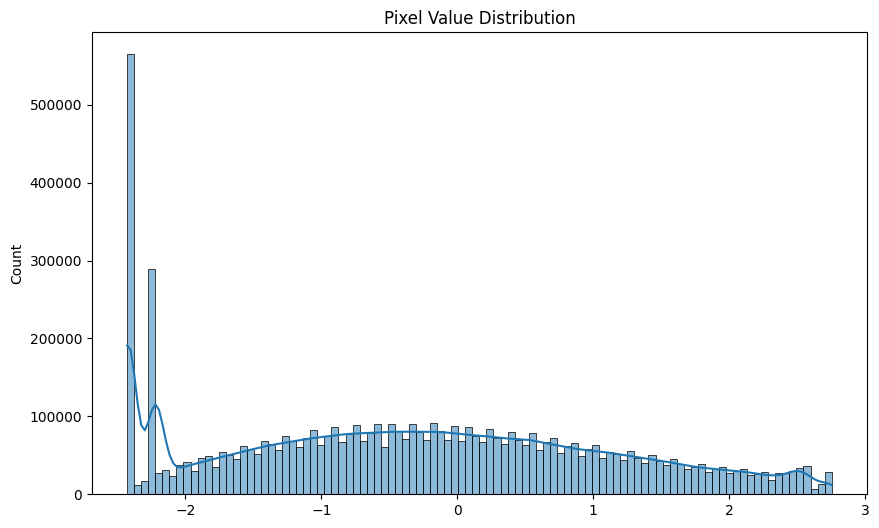

In [6]:
all_pixel = []

for i in range(2000):
    img,_ = full_train_dataset[i]
    all_pixel.extend(img.flatten().numpy())

plt.figure(figsize=(10,6))
sns.histplot(all_pixel,bins=100,kde=True)
plt.title('Pixel Value Distribution')
plt.show()


<h2>Input structure of the layers</h2>

I will pass the conv layer like a list of dict

[{type: Conv/Pool,<br>
out_layer:,<br>
kernel_size:,<br>stride: }]

In [14]:
class FlexibleCNN(Module):
    def __init__(self, conv_config,fc_config,num_classes=10,activation='relu'):
        super(FlexibleCNN,self).__init__()

        self.activation = activation

        conv_layer = []
        in_channels = 3

        for cfg in conv_config:
            if cfg['type'] == 'conv':
                conv_layer.append(Conv2d(
                    in_channels=in_channels,
                    out_channels=cfg['out_channels'],
                    kernel_size=cfg.get('kernel_size',3),
                    stride=cfg.get('stride',1),
                    padding=cfg.get('padding',1)
                ))
                conv_layer.append(BatchNorm2d(cfg['out_channels']))
                act = cfg.get('activation',self.activation)
                conv_layer.append(self._get_activation(act))
                in_channels = cfg['out_channels']
            else:
                conv_layer.append(MaxPool2d(
                    kernel_size=cfg.get('kernel_size',2),
                    stride=cfg.get('stride',2),
                    padding=cfg.get('padding',0)
                ))

        self.conv_part = Sequential(*conv_layer)

        with torch.no_grad():
            dummy = torch.zeros(1,3,32,32)
            flat_dim = self.conv_part(dummy).view(1,-1).size(1)

        fc_layer = []
        in_features = flat_dim

        for hidden in fc_config:
            if hidden['type'] == 'fc':
                fc_layer.append(Linear(
                    in_features=in_features,
                    out_features=hidden['out_features']
                ))
                act = hidden.get('activation',self.activation)
                fc_layer.append(self._get_activation(act))
                in_features = hidden['out_features']
            else:
                fc_layer.append(Dropout(p=hidden.get('p',0.5)))
        fc_layer.append(Linear(in_features,num_classes))
            
        self.fc_part = Sequential(*fc_layer)

    def _get_activation(self,act):
        if act == 'relu':
            return ReLU()
        elif act == 'sigmoid':
            return Sigmoid()
        elif act == 'tanh':
            return Tanh()

    def forward(self,x):
        x = self.conv_part(x)
        x = torch.flatten(x,1)
        x = self.fc_part(x)
        return x

In [15]:
def train_one_epoch(model,criterion,optimizer,dataloader,device):
    model.train()

    running_loss = 0.0
    correct,total = 0,0

    for images,labels in tqdm(dataloader,leave=False):
        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _,predicted = torch.max(output,1)
        correct += (predicted==labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss/total
    epoch_acc = correct/total

    return epoch_loss,epoch_acc

In [16]:
def eval(model,criterion,dataloader,device):
    model.eval()

    running_loss = 0.0
    correct,total = 0,0

    for images,labels in tqdm(dataloader,leave=False):
        images,labels = images.to(device), labels.to(device)
        output = model(images)

        loss = criterion(output,labels)

        running_loss += loss.item() * images.size(0)
        _,predicted = torch.max(output,1)
        correct += (predicted==labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss/total
    epoch_acc = correct/total
    
    return epoch_loss,epoch_acc

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr',1e-4,1e-1,log=True)
    dropout_p = trial.suggest_float('dropout_p',0.2,0.6)
    cfg_size = trial.suggest_categorical('cfg_size',[32,64,128])
    activation = trial.suggest_categorical('activation',['relu','sigmoid','tanh'])
    num_fc_layers = trial.suggest_int("num_fc_layers", 1, 3)  # 1–3 FC layers
    hidden_size = trial.suggest_categorical("hidden_size", [128, 256, 512])
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "Adagrad"])
    num_conv_layers = trial.suggest_int("num_conv_layers",2,4)
    reduction_factor = trial.suggest_float('reduction_factor',0.5,1.0)

    if optimizer_name == 'SGD':
        momentum_val = trial.suggest_float("momentum_val", 0.4, 0.9)
    else:
        momentum_val = 0.0

    conv_config = []
    for i in range(num_conv_layers):
        if i < 2:
            conv_config.append({'type':'conv','out_channels':cfg_size*(i+1),'activation':activation})
        else:
            conv_config.append({'type':'conv','out_channels':cfg_size*3,'activation':activation})
        conv_config.append({'type':'maxpool'})

    fc_config = []
    for i in range(num_fc_layers):
        fc_config.append({'type':'fc','out_features':int(hidden_size*(reduction_factor**i)),'activation':activation})
        fc_config.append({'type': 'dropout','p': dropout_p})

    trial.set_user_attr('conv_architecture',conv_config)
    trial.set_user_attr('fc_architecture',fc_config)

    K = 3
    kfold = KFold(n_splits=K,shuffle=True,random_state=42)
    fold_val_acc = []
    all_indices = np.arange(len(full_train_dataset))

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for fold,(train_index,val_index) in enumerate(kfold.split(all_indices)):

        current_train_dataset = Subset(full_train_dataset,train_index)
        current_val_dataset = Subset(full_train_dataset,val_index)

        train_loader = DataLoader(current_train_dataset,batch_size=64,shuffle=True,num_workers=2)
        val_loader = DataLoader(current_val_dataset,batch_size=64,shuffle=False,num_workers=2)
    

        model = FlexibleCNN(conv_config,fc_config,10,activation).to(device)

        criterion = CrossEntropyLoss()

        if optimizer_name == 'SGD':
            optimizer = SGD(model.parameters(),momentum=momentum_val,lr=lr)
        elif optimizer_name == 'Adam':
            optimizer = Adam(model.parameters(),lr=lr)
        elif optimizer_name == 'Adagrad':
            optimizer = Adagrad(model.parameters(),lr=lr)

        for epoch in range(10):
            train_one_epoch(model,criterion,optimizer,train_loader,device)

        _, val_acc = eval(model,criterion,val_loader,device)
        fold_val_acc.append(val_acc)
        print(f"Fold {fold+1} Validation Accuracy: {val_acc:.4f}")

    mean_val_acc = np.mean(fold_val_acc)
    trial.set_user_attr('mean_val_acc', mean_val_acc)
    
    return mean_val_acc


In [18]:
study = optuna.create_study(direction='maximize')

study.optimize(objective,n_trials=50)

best_params = study.best_trial.params
best_score = study.best_trial.value
best_architectre = study.best_trial.user_attrs

print("Best trial:")
print("  Value:", best_score)
print("  Params:", best_params)

[I 2025-10-30 17:17:58,786] A new study created in memory with name: no-name-0a1fc29f-f233-4d50-899d-63853b7daf5d


Fold 1 Validation Accuracy: 0.4108


Fold 2 Validation Accuracy: 0.4097


[I 2025-10-30 17:21:32,825] Trial 0 finished with value: 0.41906035394232716 and parameters: {'lr': 0.016009026737887594, 'dropout_p': 0.49254353342401386, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 1, 'hidden_size': 256, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.8688341758327949}. Best is trial 0 with value: 0.41906035394232716.


Fold 3 Validation Accuracy: 0.4368


Fold 1 Validation Accuracy: 0.1577


Fold 2 Validation Accuracy: 0.1925


[I 2025-10-30 17:26:05,471] Trial 1 finished with value: 0.17762010054410696 and parameters: {'lr': 0.00019334703180764738, 'dropout_p': 0.4804139205012358, 'cfg_size': 32, 'activation': 'sigmoid', 'num_fc_layers': 2, 'hidden_size': 128, 'optimizer': 'Adagrad', 'num_conv_layers': 3, 'reduction_factor': 0.664744640881308}. Best is trial 0 with value: 0.41906035394232716.


Fold 3 Validation Accuracy: 0.1826


Fold 1 Validation Accuracy: 0.6225


Fold 2 Validation Accuracy: 0.6200


[I 2025-10-30 17:36:03,763] Trial 2 finished with value: 0.6253601641035701 and parameters: {'lr': 0.0070931776168249175, 'dropout_p': 0.250472985473029, 'cfg_size': 64, 'activation': 'tanh', 'num_fc_layers': 1, 'hidden_size': 128, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.7976234295394264}. Best is trial 2 with value: 0.6253601641035701.


Fold 3 Validation Accuracy: 0.6336


Fold 1 Validation Accuracy: 0.7023


Fold 2 Validation Accuracy: 0.6969


[I 2025-10-30 17:44:43,875] Trial 3 finished with value: 0.6897996061439625 and parameters: {'lr': 0.0005005062886581839, 'dropout_p': 0.27567349075191355, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 3, 'reduction_factor': 0.8775224336526865}. Best is trial 3 with value: 0.6897996061439625.


Fold 3 Validation Accuracy: 0.6701


Fold 1 Validation Accuracy: 0.5699


Fold 2 Validation Accuracy: 0.5594


[I 2025-10-30 18:04:21,752] Trial 4 finished with value: 0.5626599204485369 and parameters: {'lr': 0.05473465806808162, 'dropout_p': 0.40171165602836456, 'cfg_size': 128, 'activation': 'tanh', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'SGD', 'num_conv_layers': 3, 'reduction_factor': 0.6232688040338624, 'momentum_val': 0.7893950402805117}. Best is trial 3 with value: 0.6897996061439625.


Fold 3 Validation Accuracy: 0.5587


Fold 1 Validation Accuracy: 0.1021


Fold 2 Validation Accuracy: 0.0972


[I 2025-10-30 18:23:44,668] Trial 5 finished with value: 0.09903997527873755 and parameters: {'lr': 0.022045052469127833, 'dropout_p': 0.5166798636073726, 'cfg_size': 128, 'activation': 'sigmoid', 'num_fc_layers': 2, 'hidden_size': 128, 'optimizer': 'Adam', 'num_conv_layers': 3, 'reduction_factor': 0.6316607826669236}. Best is trial 3 with value: 0.6897996061439625.


Fold 3 Validation Accuracy: 0.0978


Fold 1 Validation Accuracy: 0.2273


Fold 2 Validation Accuracy: 0.2365


[I 2025-10-30 18:42:52,730] Trial 6 finished with value: 0.236180171392372 and parameters: {'lr': 0.00030403099815045536, 'dropout_p': 0.254723525389158, 'cfg_size': 128, 'activation': 'sigmoid', 'num_fc_layers': 1, 'hidden_size': 128, 'optimizer': 'SGD', 'num_conv_layers': 3, 'reduction_factor': 0.8839116073292896, 'momentum_val': 0.5063429877725434}. Best is trial 3 with value: 0.6897996061439625.


Fold 3 Validation Accuracy: 0.2447


Fold 1 Validation Accuracy: 0.5394


Fold 2 Validation Accuracy: 0.5622


[I 2025-10-30 18:51:52,003] Trial 7 finished with value: 0.5493799412383287 and parameters: {'lr': 0.0016128065127651299, 'dropout_p': 0.5116367738379763, 'cfg_size': 32, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adagrad', 'num_conv_layers': 3, 'reduction_factor': 0.558584478965128}. Best is trial 3 with value: 0.6897996061439625.


Fold 3 Validation Accuracy: 0.5464


Fold 1 Validation Accuracy: 0.0970


Fold 2 Validation Accuracy: 0.0972


[I 2025-10-30 19:10:02,044] Trial 8 finished with value: 0.09732000967804956 and parameters: {'lr': 0.005063989263336384, 'dropout_p': 0.29392807389384973, 'cfg_size': 128, 'activation': 'sigmoid', 'num_fc_layers': 3, 'hidden_size': 256, 'optimizer': 'Adagrad', 'num_conv_layers': 2, 'reduction_factor': 0.7393087358469621}. Best is trial 3 with value: 0.6897996061439625.


Fold 3 Validation Accuracy: 0.0978


Fold 1 Validation Accuracy: 0.6690


Fold 2 Validation Accuracy: 0.6559


[I 2025-10-30 19:21:09,937] Trial 9 finished with value: 0.6626400065302426 and parameters: {'lr': 0.00014179154278123863, 'dropout_p': 0.3372687324209172, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 256, 'optimizer': 'Adam', 'num_conv_layers': 2, 'reduction_factor': 0.9041251735859763}. Best is trial 3 with value: 0.6897996061439625.


Fold 3 Validation Accuracy: 0.6630


Fold 1 Validation Accuracy: 0.7055


Fold 2 Validation Accuracy: 0.7053


[I 2025-10-30 19:30:16,067] Trial 10 finished with value: 0.700059786155771 and parameters: {'lr': 0.0010703894040575955, 'dropout_p': 0.37736294439033075, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.999419876221851}. Best is trial 10 with value: 0.700059786155771.


Fold 3 Validation Accuracy: 0.6894


Fold 1 Validation Accuracy: 0.7138


Fold 2 Validation Accuracy: 0.7022


[I 2025-10-30 19:39:32,178] Trial 11 finished with value: 0.7099600777695235 and parameters: {'lr': 0.0012740414074354665, 'dropout_p': 0.37514251662195536, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.9773028467644422}. Best is trial 11 with value: 0.7099600777695235.


Fold 3 Validation Accuracy: 0.7138


Fold 1 Validation Accuracy: 0.7162


Fold 2 Validation Accuracy: 0.7149


[I 2025-10-30 19:48:45,447] Trial 12 finished with value: 0.7123998729673793 and parameters: {'lr': 0.0011862356739549918, 'dropout_p': 0.39845614109468, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.9924403017895677}. Best is trial 12 with value: 0.7123998729673793.


Fold 3 Validation Accuracy: 0.7060


Fold 1 Validation Accuracy: 0.6939


Fold 2 Validation Accuracy: 0.7095


[I 2025-10-30 19:58:04,020] Trial 13 finished with value: 0.7029400501633553 and parameters: {'lr': 0.0017408903412042063, 'dropout_p': 0.42273347894729646, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.9997232869377439}. Best is trial 12 with value: 0.7123998729673793.


Fold 3 Validation Accuracy: 0.7054


Fold 1 Validation Accuracy: 0.6878


Fold 2 Validation Accuracy: 0.6999


[I 2025-10-30 20:07:26,478] Trial 14 finished with value: 0.6966001109594994 and parameters: {'lr': 0.00083093880431211, 'dropout_p': 0.4382315511104453, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.9382578388033307}. Best is trial 12 with value: 0.7123998729673793.


Fold 3 Validation Accuracy: 0.7021


Fold 1 Validation Accuracy: 0.6813


Fold 2 Validation Accuracy: 0.6719


[I 2025-10-30 20:16:17,595] Trial 15 finished with value: 0.6733998729361786 and parameters: {'lr': 0.002602605791542097, 'dropout_p': 0.5982379694259197, 'cfg_size': 32, 'activation': 'tanh', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'SGD', 'num_conv_layers': 4, 'reduction_factor': 0.8014076533190294, 'momentum_val': 0.8976170472698832}. Best is trial 12 with value: 0.7123998729673793.


Fold 3 Validation Accuracy: 0.6670


Fold 1 Validation Accuracy: 0.7733


Fold 2 Validation Accuracy: 0.7773


[I 2025-10-30 20:28:34,809] Trial 16 finished with value: 0.769039750610244 and parameters: {'lr': 0.0005026623100969808, 'dropout_p': 0.34571618524151304, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.9511685783253532}. Best is trial 16 with value: 0.769039750610244.


Fold 3 Validation Accuracy: 0.7566


Fold 1 Validation Accuracy: 0.7564


Fold 2 Validation Accuracy: 0.7632


[I 2025-10-30 20:41:04,263] Trial 17 finished with value: 0.758899964206404 and parameters: {'lr': 0.0004791189512668186, 'dropout_p': 0.33032170628200214, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.8209571189646022}. Best is trial 16 with value: 0.769039750610244.


Fold 3 Validation Accuracy: 0.7571


Fold 1 Validation Accuracy: 0.5467


Fold 2 Validation Accuracy: 0.5411


[I 2025-10-30 20:53:16,850] Trial 18 finished with value: 0.5453200572374008 and parameters: {'lr': 0.00043215603609105327, 'dropout_p': 0.2136070686968178, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adagrad', 'num_conv_layers': 2, 'reduction_factor': 0.8141331924323485}. Best is trial 16 with value: 0.769039750610244.


Fold 3 Validation Accuracy: 0.5482


Fold 1 Validation Accuracy: 0.2097


Fold 2 Validation Accuracy: 0.2456


[I 2025-10-30 21:05:30,536] Trial 19 finished with value: 0.232820207390404 and parameters: {'lr': 0.00023272513564970854, 'dropout_p': 0.3250820875041179, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 256, 'optimizer': 'SGD', 'num_conv_layers': 4, 'reduction_factor': 0.7323035233496522, 'momentum_val': 0.4179895649592854}. Best is trial 16 with value: 0.769039750610244.


Fold 3 Validation Accuracy: 0.2432


Fold 1 Validation Accuracy: 0.7367


Fold 2 Validation Accuracy: 0.7110


[I 2025-10-30 21:17:54,886] Trial 20 finished with value: 0.7289202013871638 and parameters: {'lr': 0.00041658633871575015, 'dropout_p': 0.3455582410206127, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 3, 'reduction_factor': 0.5051108636052573}. Best is trial 16 with value: 0.769039750610244.


Fold 3 Validation Accuracy: 0.7390


Fold 1 Validation Accuracy: 0.7137


Fold 2 Validation Accuracy: 0.7184


[I 2025-10-30 21:30:31,948] Trial 21 finished with value: 0.7128998725677712 and parameters: {'lr': 0.00010631653530231885, 'dropout_p': 0.3278465267029849, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 3, 'reduction_factor': 0.5043819149040507}. Best is trial 16 with value: 0.769039750610244.


Fold 3 Validation Accuracy: 0.7065


Fold 1 Validation Accuracy: 0.7758


Fold 2 Validation Accuracy: 0.7537


[I 2025-10-30 21:43:23,958] Trial 22 finished with value: 0.7696001942195645 and parameters: {'lr': 0.0005214348064713633, 'dropout_p': 0.3417404594576189, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6970676465310893}. Best is trial 22 with value: 0.7696001942195645.


Fold 3 Validation Accuracy: 0.7793


Fold 1 Validation Accuracy: 0.7775


Fold 2 Validation Accuracy: 0.7733


[I 2025-10-30 21:56:27,663] Trial 23 finished with value: 0.7725998882158444 and parameters: {'lr': 0.0006317271946087535, 'dropout_p': 0.3077393021818934, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6837061506765642}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7670


Fold 1 Validation Accuracy: 0.7194


Fold 2 Validation Accuracy: 0.7476


[I 2025-10-30 22:09:17,730] Trial 24 finished with value: 0.7314399157834677 and parameters: {'lr': 0.003417064984221423, 'dropout_p': 0.2934857161034469, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.688442112792285}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7272


Fold 1 Validation Accuracy: 0.7804


Fold 2 Validation Accuracy: 0.7480


[I 2025-10-30 22:23:19,127] Trial 25 finished with value: 0.7667401014154204 and parameters: {'lr': 0.0007083502711175939, 'dropout_p': 0.21295811784625582, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.7045370445286512}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7718


Fold 1 Validation Accuracy: 0.7822


Fold 2 Validation Accuracy: 0.7580


[I 2025-10-30 22:37:14,930] Trial 26 finished with value: 0.7715800586184365 and parameters: {'lr': 0.00027554180390971855, 'dropout_p': 0.3656543489879751, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.5936513153012226}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7745


Fold 1 Validation Accuracy: 0.7304


Fold 2 Validation Accuracy: 0.7433


[I 2025-10-30 22:51:00,189] Trial 27 finished with value: 0.7338198789846357 and parameters: {'lr': 0.00023860383129456798, 'dropout_p': 0.4425511454307564, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 256, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.582262665928504}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7278


Fold 1 Validation Accuracy: 0.1688


Fold 2 Validation Accuracy: 0.1962


[I 2025-10-30 23:04:41,470] Trial 28 finished with value: 0.17745979893794658 and parameters: {'lr': 0.00010414225366607783, 'dropout_p': 0.30261987855372185, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 128, 'optimizer': 'SGD', 'num_conv_layers': 4, 'reduction_factor': 0.6377744753799234, 'momentum_val': 0.6428102670124031}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.1674


Fold 1 Validation Accuracy: 0.7563


Fold 2 Validation Accuracy: 0.7446


[I 2025-10-30 23:19:05,864] Trial 29 finished with value: 0.7590003402140045 and parameters: {'lr': 0.010457093817045142, 'dropout_p': 0.3665547929462253, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adagrad', 'num_conv_layers': 4, 'reduction_factor': 0.587368855552075}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7760


Fold 1 Validation Accuracy: 0.7418


Fold 2 Validation Accuracy: 0.7403


[I 2025-10-30 23:32:30,678] Trial 30 finished with value: 0.7362998089852196 and parameters: {'lr': 0.0007814935769761028, 'dropout_p': 0.2465217545034003, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 256, 'optimizer': 'Adam', 'num_conv_layers': 3, 'reduction_factor': 0.7696125448188105}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7267


Fold 1 Validation Accuracy: 0.7773


Fold 2 Validation Accuracy: 0.7703


[I 2025-10-30 23:46:24,583] Trial 31 finished with value: 0.7654396654056598 and parameters: {'lr': 0.00031848295885982653, 'dropout_p': 0.3539057088247009, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6816704212045398}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7487


Fold 1 Validation Accuracy: 0.7652


Fold 2 Validation Accuracy: 0.7653


[I 2025-10-31 00:01:40,756] Trial 32 finished with value: 0.7592397582025558 and parameters: {'lr': 0.00015684860137186516, 'dropout_p': 0.31051555964455524, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.7184243730882125}. Best is trial 23 with value: 0.7725998882158444.


Fold 3 Validation Accuracy: 0.7471


Fold 1 Validation Accuracy: 0.7668


Fold 2 Validation Accuracy: 0.7760


[I 2025-10-31 00:16:23,926] Trial 33 finished with value: 0.7743801190218845 and parameters: {'lr': 0.0005949836583868605, 'dropout_p': 0.39701143296365304, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6554069145188348}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.7803


Fold 1 Validation Accuracy: 0.7539


Fold 2 Validation Accuracy: 0.7601


[I 2025-10-31 00:30:08,792] Trial 34 finished with value: 0.7548999146022121 and parameters: {'lr': 0.0023283597907114983, 'dropout_p': 0.40905508308258304, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6497326522623796}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.7506


Fold 1 Validation Accuracy: 0.2452


Fold 2 Validation Accuracy: 0.4405


[I 2025-10-31 00:44:04,922] Trial 35 finished with value: 0.32813941225075655 and parameters: {'lr': 0.0006532533993405369, 'dropout_p': 0.4680003867512709, 'cfg_size': 64, 'activation': 'sigmoid', 'num_fc_layers': 2, 'hidden_size': 128, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.5462655025043812}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.2988


Fold 1 Validation Accuracy: 0.7862


Fold 2 Validation Accuracy: 0.7653


[I 2025-10-31 00:57:16,579] Trial 36 finished with value: 0.7726598762156521 and parameters: {'lr': 0.0002675721008958428, 'dropout_p': 0.3825846848352859, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6112894228832289}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.7665


Fold 1 Validation Accuracy: 0.5720


Fold 2 Validation Accuracy: 0.5661


[I 2025-10-31 01:17:12,855] Trial 37 finished with value: 0.567519938452785 and parameters: {'lr': 0.00019219900285695653, 'dropout_p': 0.38119643810173454, 'cfg_size': 128, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 128, 'optimizer': 'Adagrad', 'num_conv_layers': 3, 'reduction_factor': 0.6031281907942073}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.5644


Fold 1 Validation Accuracy: 0.4882


Fold 2 Validation Accuracy: 0.6034


[I 2025-10-31 01:28:03,156] Trial 38 finished with value: 0.5432398984325606 and parameters: {'lr': 0.00032780449950657196, 'dropout_p': 0.47275224944784067, 'cfg_size': 64, 'activation': 'sigmoid', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 3, 'reduction_factor': 0.6673453501673303}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.5382


Fold 1 Validation Accuracy: 0.5885


Fold 2 Validation Accuracy: 0.5861


[I 2025-10-31 01:51:05,122] Trial 39 finished with value: 0.5877800192706094 and parameters: {'lr': 0.0002709417568257775, 'dropout_p': 0.4513834576768902, 'cfg_size': 128, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'SGD', 'num_conv_layers': 4, 'reduction_factor': 0.6068462836953809, 'momentum_val': 0.6704140688931636}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.5887


Fold 1 Validation Accuracy: 0.1027


Fold 2 Validation Accuracy: 0.5076


[I 2025-10-31 02:02:56,308] Trial 40 finished with value: 0.38330312716918585 and parameters: {'lr': 0.01876267548629954, 'dropout_p': 0.2740698063659404, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 3, 'reduction_factor': 0.5534887507975403}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.5397


Fold 1 Validation Accuracy: 0.1007


Fold 2 Validation Accuracy: 0.1036


[I 2025-10-31 02:15:38,995] Trial 41 finished with value: 0.10107995848003358 and parameters: {'lr': 0.088085324348636, 'dropout_p': 0.4005469345430109, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.7575044025794324}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.0990


Fold 1 Validation Accuracy: 0.7419


Fold 2 Validation Accuracy: 0.7589


[I 2025-10-31 02:29:26,636] Trial 42 finished with value: 0.7523200766033882 and parameters: {'lr': 0.00017015182808089225, 'dropout_p': 0.38811543638930934, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 3, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6559595534189803}. Best is trial 33 with value: 0.7743801190218845.


Fold 3 Validation Accuracy: 0.7562


Fold 1 Validation Accuracy: 0.7942


Fold 2 Validation Accuracy: 0.7643


[I 2025-10-31 02:43:27,940] Trial 43 finished with value: 0.7782799606218364 and parameters: {'lr': 0.0005955510018743252, 'dropout_p': 0.4206022427043735, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6243750103694886}. Best is trial 43 with value: 0.7782799606218364.


Fold 3 Validation Accuracy: 0.7763


Fold 1 Validation Accuracy: 0.3777


Fold 2 Validation Accuracy: 0.4334


[I 2025-10-31 02:57:44,745] Trial 44 finished with value: 0.36099821865317167 and parameters: {'lr': 0.0010348673536669172, 'dropout_p': 0.42351511465269737, 'cfg_size': 64, 'activation': 'sigmoid', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6185169392046848}. Best is trial 43 with value: 0.7782799606218364.


Fold 3 Validation Accuracy: 0.2719


Fold 1 Validation Accuracy: 0.7607


Fold 2 Validation Accuracy: 0.7649


[I 2025-10-31 03:25:12,985] Trial 45 finished with value: 0.757299780201444 and parameters: {'lr': 0.0018608017145949418, 'dropout_p': 0.49115601137728293, 'cfg_size': 128, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 128, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.584117251894878}. Best is trial 43 with value: 0.7782799606218364.


Fold 3 Validation Accuracy: 0.7463


Fold 1 Validation Accuracy: 0.6077


Fold 2 Validation Accuracy: 0.6000


[I 2025-10-31 03:38:59,054] Trial 46 finished with value: 0.6041400112835377 and parameters: {'lr': 0.00034304531617743297, 'dropout_p': 0.3648398001894229, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adagrad', 'num_conv_layers': 4, 'reduction_factor': 0.6351436815628755}. Best is trial 43 with value: 0.7782799606218364.


Fold 3 Validation Accuracy: 0.6047


Fold 1 Validation Accuracy: 0.7571


Fold 2 Validation Accuracy: 0.7175


[I 2025-10-31 03:52:17,706] Trial 47 finished with value: 0.7428802221987482 and parameters: {'lr': 0.0038929076880570954, 'dropout_p': 0.40995801473416876, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 256, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.5432295590146747}. Best is trial 43 with value: 0.7782799606218364.


Fold 3 Validation Accuracy: 0.7540


Fold 1 Validation Accuracy: 0.4010


Fold 2 Validation Accuracy: 0.4378


[I 2025-10-31 04:04:42,589] Trial 48 finished with value: 0.41931999593537467 and parameters: {'lr': 0.0006201586306281328, 'dropout_p': 0.546651618761657, 'cfg_size': 64, 'activation': 'sigmoid', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 2, 'reduction_factor': 0.6694212642549707}. Best is trial 43 with value: 0.7782799606218364.


Fold 3 Validation Accuracy: 0.4191


Fold 1 Validation Accuracy: 0.6192


Fold 2 Validation Accuracy: 0.5970


[I 2025-10-31 04:27:47,095] Trial 49 finished with value: 0.6111801224913939 and parameters: {'lr': 0.0009698041996410166, 'dropout_p': 0.4280279673849882, 'cfg_size': 128, 'activation': 'relu', 'num_fc_layers': 2, 'hidden_size': 512, 'optimizer': 'SGD', 'num_conv_layers': 4, 'reduction_factor': 0.5288973416602779, 'momentum_val': 0.5679588411518758}. Best is trial 43 with value: 0.7782799606218364.


Fold 3 Validation Accuracy: 0.6173
Best trial:
  Value: 0.7782799606218364
  Params: {'lr': 0.0005955510018743252, 'dropout_p': 0.4206022427043735, 'cfg_size': 64, 'activation': 'relu', 'num_fc_layers': 1, 'hidden_size': 512, 'optimizer': 'Adam', 'num_conv_layers': 4, 'reduction_factor': 0.6243750103694886}


In [21]:
best_conv_architecture = best_architectre['conv_architecture']
best_fc_architecture = best_architectre['fc_architecture']
best_num_filters = best_params['cfg_size']
best_activation = best_params['activation']
best_num_fc_layers = best_params['num_fc_layers']
best_hidden_size = best_params['hidden_size']
best_dropout_p = best_params['dropout_p']
best_lr = best_params['lr']
best_optimizer_name = best_params['optimizer']
best_momentum_val = best_params.get('momentum_val', 0.0) 

final_conv_config = best_conv_architecture
# [
#     {'type': 'conv', 'out_channels': best_num_filters},
#     {'type': 'maxpool'},
#     {'type': 'dropout', 'p': best_dropout_p},
#     {'type': 'conv', 'out_channels': best_num_filters * 2},
#     {'type': 'maxpool'}
# ]

final_fc_config = best_fc_architecture
# final_in_features = best_hidden_size
# for _ in range(best_num_fc_layers):
#     final_fc_config.append({'out_features': final_in_features, 'activation': best_activation})


device = 'cuda' if torch.cuda.is_available() else 'cpu'

final_model = FlexibleCNN(final_conv_config, final_fc_config, 10, best_activation).to(device)
final_criterion = CrossEntropyLoss()

if best_optimizer_name == 'SGD':
    final_optimizer = SGD(final_model.parameters(), momentum=best_momentum_val, lr=best_lr)
elif best_optimizer_name == 'Adam':
    final_optimizer = Adam(final_model.parameters(), lr=best_lr)
elif best_optimizer_name == 'Adagrad':
    final_optimizer = Adagrad(final_model.parameters(), lr=best_lr)
else:
    raise ValueError("Optimizer not recognized.")

final_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True, num_workers=2)

for epoch in range(50): 
    train_one_epoch(final_model, final_criterion, final_optimizer, final_train_loader, device)


_, test_acc = eval(final_model, final_criterion, test_loader, device) 

print(f"Final Test Accuracy: {test_acc*100:.4f}")


Final Test Accuracy: 87.3800


In [22]:
print("Conv_Architecture",best_conv_architecture)
print("FC_Architecture",best_fc_architecture)

Conv_Architecture [{'type': 'conv', 'out_channels': 64, 'activation': 'relu'}, {'type': 'maxpool'}, {'type': 'conv', 'out_channels': 128, 'activation': 'relu'}, {'type': 'maxpool'}, {'type': 'conv', 'out_channels': 192, 'activation': 'relu'}, {'type': 'maxpool'}, {'type': 'conv', 'out_channels': 192, 'activation': 'relu'}, {'type': 'maxpool'}]
FC_Architecture [{'type': 'fc', 'out_features': 512, 'activation': 'relu'}, {'type': 'dropout', 'p': 0.4206022427043735}]
